# Lockout: Quick User's Guide

A synthetic dataset was generated and partitioned into training, validation, and testing subsets and it is used througout this guide.

## Create DataLoaders
Change this section according to your particular problem to build training, validation, and testing DataLoaders.

In [36]:
from lockout.pytorch_utils import load_data_reg, normalize_xy, make_DataLoaders
from lockout.utils import read_list

# Read Data
_, x_train, x_valid, x_test, _, y_train, y_valid, y_test = load_data_reg('dataset/')

# Normalize Data
xtrain, xvalid, xtest, ytrain, yvalid, ytest = normalize_xy(x_train, x_valid, x_test, 
                                                            y_train, y_valid, y_test)

# Create DataLoaders
dl_train, dl_valid, dl_test = make_DataLoaders(xtrain, xvalid, xtest, ytrain, yvalid, ytest)

## Neural Network Architecture
Change this section to use a different architecture.

In [2]:
from lockout.pytorch_utils import FCNN

# Number of Input features
n_features  = 100       

# Nodes per layer:
# - len(layer_sizes) = number of layers in the network
# - layer_sizes[i]   = number of nodes in the ith layer
layer_sizes = [10, 1]   

# Instantiate Neural Network (with ReLUs)
model_init = FCNN(n_features, layer_sizes)
model_init

FCNN(
  (linear_layers): ModuleList(
    (0): Linear(in_features=100, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=1, bias=True)
  )
  (relu): ReLU(inplace=True)
)

## Unconstrained Training
Change this section to use different hyperparameters. This problem is a regression task.

In [3]:
from lockout import Lockout

# Learning rate
lr = 1e-2

# Loss function id:
# - loss_type = 1: Mean Squared Error
# - loss_type = 2: Mean Cross Entropy Loss
loss_type = 1

# Optimizer id:
# - optim_id = 1: Stochastic Gradient Descend
# - optim_id = 2: Adam
optim_id = 1

# Instantiate Lockout
lockout_forward = Lockout(model_init, 
                          lr=lr, 
                          loss_type=loss_type, 
                          optim_id=optim_id)

# Train Neural Network Without Regularization
lockout_forward.train(dl_train, dl_valid, 
                      train_how="unconstrained",
                      epochs=10000,              # Max number of epochs
                      early_stopping=20,         # Epoch used for convergence condition
                      tol_loss=1e-6,             # Tolerance in training loss used for convergence condition
                      reset_weights=True)        # Whether or not to reset weights before training

Epochs:  53%|█████▎    | 5314/10000 [01:37<01:25, 54.74it/s]

Early stopping = True
Last iteration = 5315
Best validation at iteration = 348


In [23]:
from lockout.pytorch_utils import save_model

# Retrieve and Save Unconstrained Model
model_forward_unconstrained = lockout_forward.model_last
save_model(model_forward_unconstrained, 'model_forward_unconstrained.pth')

# Retrieve and Save Model At Validation Minimum
model_forward_best = lockout_forward.model_best_valid
save_model(model_forward_best, 'model_forward_best.pth')

In [42]:
# Path Data
df0 = lockout_forward.path_data
df0.head()

,iteration,train_loss,valid_loss,train_accu,valid_accu
0,1,1.118341,1.188415,-0.118341,-0.105266
1,2,1.111329,1.182360,-0.111329,-0.099634
2,3,1.104635,1.176597,-0.104635,-0.094275
3,4,1.098198,1.171101,-0.098198,-0.089162
4,5,1.091971,1.165862,-0.091972,-0.084290


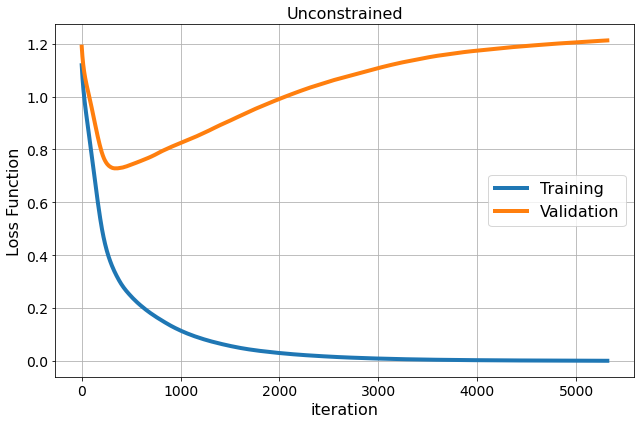

In [43]:
# Plot loss vs iteration
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(figsize=(9,6))

axes.plot(df0["iteration"], df0["train_loss"], label="Training", linewidth=4)
axes.plot(df0["iteration"], df0["valid_loss"], label="Validation", linewidth=4)
axes.legend(fontsize=16)
axes.set_xlabel("iteration", fontsize=16)
axes.set_ylabel("Loss Function", fontsize=16)
axes.tick_params(axis='both', which='major', labelsize=14)
axes.set_title("Unconstrained", fontsize=16)
axes.grid(True, zorder=2)

plt.tight_layout()
plt.savefig("loss_vs_iter_forward.pdf", bbox_inches='tight')
plt.show()

## Lockout Training: Option 1
Within this option, the network is first trained until the regularization path is found (path 1). Then, the constraint value $t_0$ is iteratively decreased (path 2) with a step size
\begin{equation}
    \Delta t_0 =\frac{{t_0}_{\mathrm{final}} - {t_0}_{\mathrm{initial}}}{\mathrm{epochs}}.
\end{equation}
A small $\Delta t_0$ is necessary to stay on the regularization path.

In [55]:
from lockout import Lockout

# List of tuples (or dictionary) of the form [(layer_name, regul_id)] where:
# - layer_name: layer name in the input model (string)
# - regul_id = 1: L1 regularization
# - regul_id = 2: Log regularization
regul_type = [('linear_layers.0.weight', 1)]

# List of tuples (or dictionary) of the form [(layer_name, path_flg)] where:
# - path_flg = True: the constraint t0 will be iteratively changed in this layer
# - path_flg = False: the constraint t0 will be kept constant in this layer
regul_path = [('linear_layers.0.weight', True)]

# Instantiate Lockout
lockout_option1 = Lockout(lockout_forward.model_best_valid,  # initial network
                          lr=1e-2, 
                          loss_type=1,
                          regul_type=regul_type,
                          regul_path=regul_path)

# Train Neural Network With Lockout
lockout_option1.train(dl_train, dl_valid, 
                      train_how="decrease_t0", 
                      epochs=5000,              # Max number of epochs used in Path 1
                      epochs2=20000,            # Max number of epochs used in Path 2
                      early_stopping=20, 
                      tol_loss=1e-5)

Epochs1:  39%|███▉      | 1970/5000 [00:39<01:00, 50.05it/s]


Path 1: Early stopping = True
        Last iteration = 1971


Epochs2: 100%|██████████| 20000/20000 [06:49<00:00, 48.79it/s]

Best validation at iteration = 19840


In [60]:
# Save Model At Validation Minimum
model_lockout_option1 = lockout_option1.model_best_valid
save_model(model_lockout_option1, 'model_lockout_option1.pth')

In [72]:
# Path Data
df1 = lockout_option1.path_data
df1.head()

,iteration,sparcity__linear_layers.0.weight,t0_calc__linear_layers.0.weight,t0_used__linear_layers.0.weight,train_loss,valid_loss,train_accu,valid_accu
0,1,1.0,54.207119,54.207119,0.326455,0.728214,0.673545,0.322737
1,2,1.0,54.207310,54.207119,0.325617,0.728189,0.674384,0.322760
2,3,1.0,54.207184,54.207119,0.324770,0.728236,0.675230,0.322716
3,4,1.0,54.207195,54.207119,0.323921,0.728168,0.676079,0.322780
4,5,1.0,54.207092,54.207119,0.323038,0.728198,0.676962,0.322752


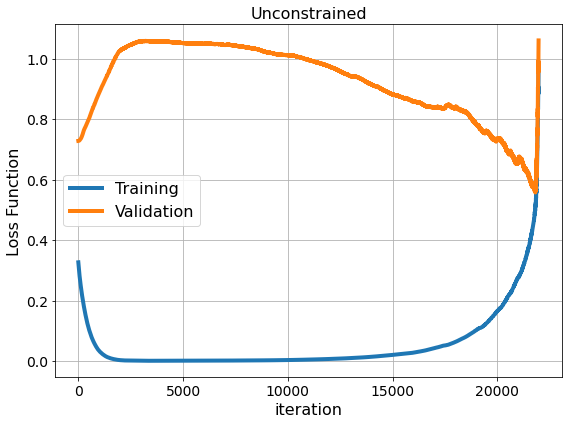

In [73]:
# Plot loss vs iteration
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(figsize=(8,6))

axes.plot(df1["iteration"], df1["train_loss"], label="Training", linewidth=4)
axes.plot(df1["iteration"], df1["valid_loss"], label="Validation", linewidth=4)
axes.legend(fontsize=16)
axes.set_xlabel("iteration", fontsize=16)
axes.set_ylabel("Loss Function", fontsize=16)
axes.tick_params(axis='both', which='major', labelsize=14)
axes.set_title("Unconstrained", fontsize=16)
axes.grid(True, zorder=2)

plt.tight_layout()
plt.savefig("loss_vs_iter_lockout1.pdf", bbox_inches='tight')
plt.show()

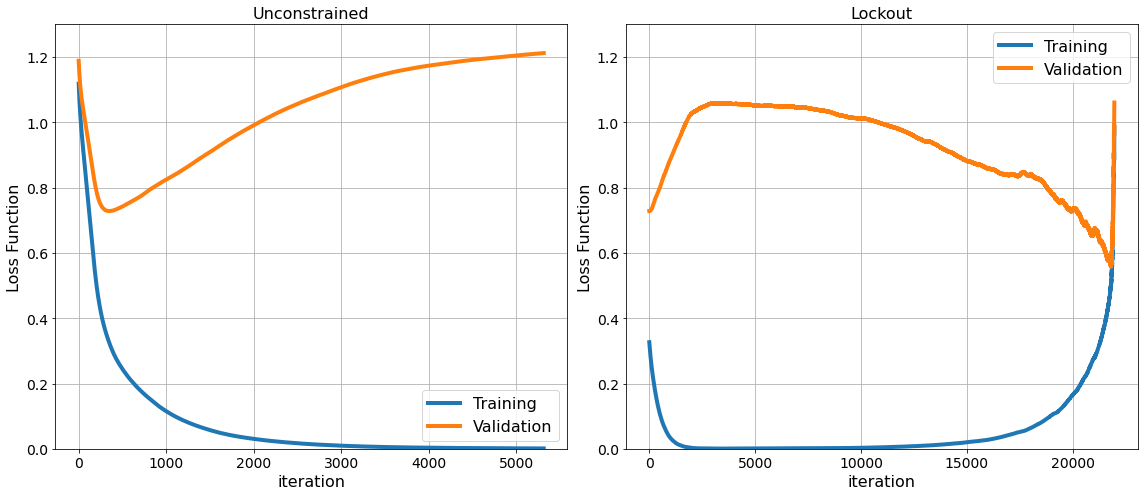

In [65]:
# Plot loss vs iteration
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,7))

axes[0].plot(df0["iteration"], df0["train_loss"], label="Training", linewidth=4)
axes[0].plot(df0["iteration"], df0["valid_loss"], label="Validation", linewidth=4)
axes[0].legend(fontsize=16)
axes[0].set_xlabel("iteration", fontsize=16)
axes[0].set_ylabel("Loss Function", fontsize=16)
axes[0].tick_params(axis='both', which='major', labelsize=14)
axes[0].set_title("Unconstrained", fontsize=16)
axes[0].grid(True, zorder=2)
axes[0].set_ylim(0,1.3)

axes[1].plot(df1["iteration"], df1["train_loss"], label="Training", linewidth=4)
axes[1].plot(df1["iteration"], df1["valid_loss"], label="Validation", linewidth=4)
axes[1].legend(fontsize=16)
axes[1].set_xlabel("iteration", fontsize=16)
axes[1].set_ylabel("Loss Function", fontsize=16)
axes[1].tick_params(axis='both', which='major', labelsize=14)
axes[1].set_title("Lockout", fontsize=16)
axes[1].grid(True, zorder=2)
axes[1].set_ylim(0,1.3)

plt.tight_layout()
plt.show()

In [74]:
# Compute Test Accuracy
import torch
from lockout.pytorch_utils import dataset_r2

device = torch.device('cpu')
r2_test_forward, _  = dataset_r2(dl_test, model_forward_best, device)
r2_test_lockout1, _ = dataset_r2(dl_test, model_lockout_option1, device)
print("Test R2 (unconstrained) = {:.3f}".format(r2_test_forward))
print("Test R2 (lockout)       = {:.3f}".format(r2_test_lockout1))

Test R2 (unconstrained) = 0.655
Test R2 (lockout)       = 0.972


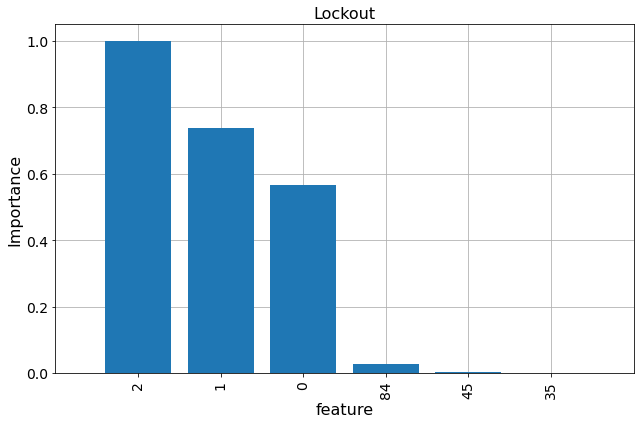

In [78]:
# Graph Feature Importance
import matplotlib.pyplot as plt
import numpy as np
from lockout.pytorch_utils import get_features_importance

importance = get_features_importance(model_lockout_option1, 'linear_layers.0.weight')

fig, axes = plt.subplots(figsize=(9,6))
x_pos = np.arange(len(importance))
axes.bar(x_pos, importance, zorder=2)
axes.set_xticks(x_pos)
axes.set_xticklabels(importance.index, rotation='vertical')
axes.set_xlim(-1,len(x_pos))
axes.tick_params(axis='both', which='major', labelsize=14)
axes.set_ylabel('Importance', fontsize=16)
axes.set_xlabel('feature', fontsize=16)
axes.set_title('Lockout', fontsize=16)
axes.grid(True, zorder=1)

plt.tight_layout()
plt.savefig('feature_importance_lockout1.pdf', bbox_inches='tight')
plt.show()

## Lockout Training: Option 2
Within this option, a discrete set $t_0$ values are sampled. The set of $t_0$s can be either:<br>
a) Entered externally as a 1D torch tensor:

In [128]:
from lockout import Lockout

regul_type = [('linear_layers.0.weight', 1)]
regul_path = [('linear_layers.0.weight', True)]

# List of tuples (or dictionary) of the form [(layer_name, t0_sampled)] where:
# - layer_name: layer name in the input model (string)
# - t0_sampled: 1D tensor with the constraint values t0 to be sampled in the layer
t0_sampled = torch.from_numpy(np.geomspace(53.504620, 1e-3, num=100, endpoint=True))
t0_grid    = {'linear_layers.0.weight': t0_sampled}

# Instantiate Lockout
lockout_option2a = Lockout(lockout_forward.model_best_valid,  # initial network
                          lr=1e-2, 
                          loss_type=1,
                          regul_type=regul_type,
                          regul_path=regul_path, 
                          t0_grid=t0_grid)

# Train Neural Network With Lockout
lockout_option2a.train(dl_train, dl_valid, 
                      train_how="sampling_t0", 
                      epochs=5000,             # Max number of epochs used for first t0
                      epochs2=200,             # Max number of epochs used for the rest of the t0 values
                      early_stopping=20, 
                      tol_loss=1e-4)

n = 1


Epochs1:  19%|█▉        | 968/5000 [00:18<01:19, 50.95it/s]


Early stopping = True (969)

n = 2


Epochs1:  72%|███████▎  | 145/200 [00:02<00:01, 49.56it/s]


Early stopping = True (146)

n = 3


Epochs1:  90%|█████████ | 180/200 [00:03<00:00, 53.58it/s]


Early stopping = True (181)

n = 4


Epochs1:  70%|██████▉   | 139/200 [00:02<00:01, 48.92it/s]


Early stopping = True (140)

n = 5


Epochs1:  86%|████████▌ | 172/200 [00:03<00:00, 49.86it/s]


Early stopping = True (173)

n = 6


Epochs1:  68%|██████▊   | 137/200 [00:02<00:01, 49.29it/s]


Early stopping = True (138)

n = 7


Epochs1:  72%|███████▎  | 145/200 [00:02<00:01, 52.37it/s]


Early stopping = True (146)

n = 8


Epochs1:  86%|████████▋ | 173/200 [00:03<00:00, 50.39it/s]


Early stopping = True (174)

n = 9


Epochs1:  81%|████████  | 162/200 [00:03<00:00, 49.43it/s]


Early stopping = True (163)

n = 10


Epochs1:  80%|████████  | 160/200 [00:03<00:00, 49.88it/s]


Early stopping = True (161)

n = 11


Epochs1:  72%|███████▎  | 145/200 [00:02<00:01, 53.02it/s]


Early stopping = True (146)

n = 12


Epochs1:  96%|█████████▌| 191/200 [00:03<00:00, 50.31it/s]


Early stopping = True (192)

n = 13


Epochs1:  59%|█████▉    | 118/200 [00:02<00:01, 48.09it/s]


Early stopping = True (119)

n = 14


Epochs1:  76%|███████▋  | 153/200 [00:03<00:00, 49.63it/s]


Early stopping = True (154)

n = 15


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 51.22it/s]


Early stopping = False (200)

n = 16


Epochs1:  44%|████▎     | 87/200 [00:01<00:02, 53.06it/s]


Early stopping = True (88)

n = 17


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 50.81it/s]


Early stopping = False (200)

n = 18


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 50.77it/s]


Early stopping = False (200)

n = 19


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 51.16it/s]


Early stopping = False (200)

n = 20


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 50.86it/s]


Early stopping = False (200)

n = 21


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 50.88it/s]


Early stopping = False (200)

n = 22


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 50.55it/s]


Early stopping = False (200)

n = 23


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 51.35it/s]


Early stopping = False (200)

n = 24


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 50.89it/s]


Early stopping = False (200)

n = 25


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 54.00it/s]


Early stopping = False (200)

n = 26


Epochs1: 100%|██████████| 200/200 [00:04<00:00, 48.71it/s]


Early stopping = False (200)

n = 27


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 54.05it/s]


Early stopping = False (200)

n = 28


Epochs1: 100%|██████████| 200/200 [00:04<00:00, 48.66it/s]


Early stopping = False (200)

n = 29


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 54.06it/s]


Early stopping = False (200)

n = 30


Epochs1: 100%|██████████| 200/200 [00:04<00:00, 48.74it/s]


Early stopping = False (200)

n = 31


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 52.81it/s]


Early stopping = False (200)

n = 32


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 50.87it/s]


Early stopping = False (200)

n = 33


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 51.31it/s]


Early stopping = False (200)

n = 34


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 51.51it/s]


Early stopping = False (200)

n = 35


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 51.31it/s]


Early stopping = False (200)

n = 36


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 51.49it/s]


Early stopping = False (200)

n = 37


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 51.37it/s]


Early stopping = False (200)

n = 38


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 51.32it/s]


Early stopping = False (200)

n = 39


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 51.21it/s]


Early stopping = False (200)

n = 40


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 51.56it/s]


Early stopping = False (200)

n = 41


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 50.62it/s]


Early stopping = False (200)

n = 42


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 50.70it/s]


Early stopping = False (200)

n = 43


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 50.90it/s]


Early stopping = False (200)

n = 44


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 50.26it/s]


Early stopping = False (200)

n = 45


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 50.69it/s]


Early stopping = False (200)

n = 46


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 54.06it/s]


Early stopping = False (200)

n = 47


Epochs1: 100%|██████████| 200/200 [00:04<00:00, 48.30it/s]


Early stopping = False (200)

n = 48


Epochs1:  32%|███▏      | 64/200 [00:01<00:02, 52.85it/s]


Early stopping = True (65)

n = 49


Epochs1:  26%|██▌       | 52/200 [00:00<00:02, 53.03it/s]


Early stopping = True (53)

n = 50


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 51.09it/s]


Early stopping = False (200)

n = 51


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 51.06it/s]


Early stopping = False (200)

n = 52


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 50.90it/s]


Early stopping = False (200)

n = 53


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 51.13it/s]


Early stopping = False (200)

n = 54


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 50.99it/s]


Early stopping = False (200)

n = 55


Epochs1: 100%|██████████| 200/200 [00:04<00:00, 49.48it/s]


Early stopping = False (200)

n = 56


Epochs1: 100%|██████████| 200/200 [00:04<00:00, 49.56it/s]


Early stopping = False (200)

n = 57


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 50.33it/s]


Early stopping = False (200)

n = 58


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 50.20it/s]


Early stopping = False (200)

n = 59


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 50.86it/s]


Early stopping = False (200)

n = 60


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 53.05it/s]


Early stopping = False (200)

n = 61


Epochs1: 100%|██████████| 200/200 [00:04<00:00, 48.00it/s]


Early stopping = False (200)

n = 62


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 53.90it/s]


Early stopping = False (200)

n = 63


Epochs1: 100%|██████████| 200/200 [00:04<00:00, 48.83it/s]


Early stopping = False (200)

n = 64


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 54.04it/s]


Early stopping = False (200)

n = 65


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 50.98it/s]


Early stopping = False (200)

n = 66


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 51.14it/s]


Early stopping = False (200)

n = 67


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 51.22it/s]


Early stopping = False (200)

n = 68


Epochs1: 100%|██████████| 200/200 [00:04<00:00, 49.96it/s]


Early stopping = False (200)

n = 69


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 50.37it/s]


Early stopping = False (200)

n = 70


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 50.72it/s]


Early stopping = False (200)

n = 71


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 50.58it/s]


Early stopping = False (200)

n = 72


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 50.86it/s]


Early stopping = False (200)

n = 73


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 51.04it/s]


Early stopping = False (200)

n = 74


Epochs1:  11%|█         | 22/200 [00:00<00:03, 50.16it/s]


Early stopping = True (23)

n = 75


Epochs1:  10%|█         | 21/200 [00:00<00:03, 49.79it/s]


Early stopping = True (22)

n = 76


Epochs1:  10%|█         | 21/200 [00:00<00:03, 50.71it/s]


Early stopping = True (22)

n = 77


Epochs1:  10%|█         | 21/200 [00:00<00:05, 34.40it/s]


Early stopping = True (22)

n = 78


Epochs1:  10%|█         | 21/200 [00:00<00:03, 50.72it/s]


Early stopping = True (22)

n = 79


Epochs1:  10%|█         | 21/200 [00:00<00:03, 49.92it/s]


Early stopping = True (22)

n = 80


Epochs1:  10%|█         | 21/200 [00:00<00:03, 50.04it/s]


Early stopping = True (22)

n = 81


Epochs1:  10%|█         | 21/200 [00:00<00:03, 50.48it/s]


Early stopping = True (22)

n = 82


Epochs1:  10%|█         | 21/200 [00:00<00:03, 50.38it/s]


Early stopping = True (22)

n = 83


Epochs1:  10%|█         | 21/200 [00:00<00:03, 50.37it/s]


Early stopping = True (22)

n = 84


Epochs1:  10%|█         | 21/200 [00:00<00:03, 50.59it/s]


Early stopping = True (22)

n = 85


Epochs1:  10%|█         | 21/200 [00:00<00:03, 50.59it/s]


Early stopping = True (22)

n = 86


Epochs1:  10%|█         | 21/200 [00:00<00:03, 49.69it/s]


Early stopping = True (22)

n = 87


Epochs1:  10%|█         | 21/200 [00:00<00:03, 49.89it/s]


Early stopping = True (22)

n = 88


Epochs1:  10%|█         | 21/200 [00:00<00:03, 50.45it/s]


Early stopping = True (22)

n = 89


Epochs1:  10%|█         | 21/200 [00:00<00:05, 33.96it/s]


Early stopping = True (22)

n = 90


Epochs1:  10%|█         | 21/200 [00:00<00:03, 50.47it/s]


Early stopping = True (22)

n = 91


Epochs1:  10%|█         | 21/200 [00:00<00:03, 50.20it/s]


Early stopping = True (22)

n = 92


Epochs1:  10%|█         | 21/200 [00:00<00:03, 48.71it/s]


Early stopping = True (22)

n = 93


Epochs1:  10%|█         | 21/200 [00:00<00:03, 50.21it/s]


Early stopping = True (22)

n = 94


Epochs1:  10%|█         | 21/200 [00:00<00:03, 50.17it/s]


Early stopping = True (22)

n = 95


Epochs1:  10%|█         | 21/200 [00:00<00:05, 33.69it/s]


Early stopping = True (22)

n = 96


Epochs1:  10%|█         | 21/200 [00:00<00:03, 51.05it/s]


Early stopping = True (22)

n = 97


Epochs1:  10%|█         | 21/200 [00:00<00:03, 50.29it/s]


Early stopping = True (22)

n = 98


Epochs1:  10%|█         | 21/200 [00:00<00:03, 50.29it/s]


Early stopping = True (22)

n = 99


Epochs1:  10%|█         | 21/200 [00:00<00:03, 50.38it/s]


Early stopping = True (22)

n = 100


Epochs1:  10%|█         | 21/200 [00:00<00:03, 50.45it/s]

Early stopping = True (22)

Best validation at iteration = 47


In [129]:
# Save Model At Validation Minimum
model_lockout_option2a = lockout_option2a.model_best_valid
save_model(model_lockout_option2a, 'model_lockout_option2a.pth')

In [130]:
# Path Data
df2a = lockout_option2a.path_data
df2a.head()

,iteration,sparcity__linear_layers.0.weight,t0_calc__linear_layers.0.weight,t0_used__linear_layers.0.weight,train_loss,valid_loss,train_accu,valid_accu
0,969,1.0,53.504848,53.504620,0.036792,0.882386,0.963208,0.179351
1,146,1.0,47.933159,47.932464,0.038469,0.869678,0.961531,0.191170
2,181,1.0,42.942211,42.940612,0.038247,0.862440,0.961753,0.197902
3,140,1.0,38.469421,38.468628,0.043386,0.850439,0.956614,0.209064
4,173,1.0,34.464169,34.462372,0.046387,0.840710,0.953613,0.218112


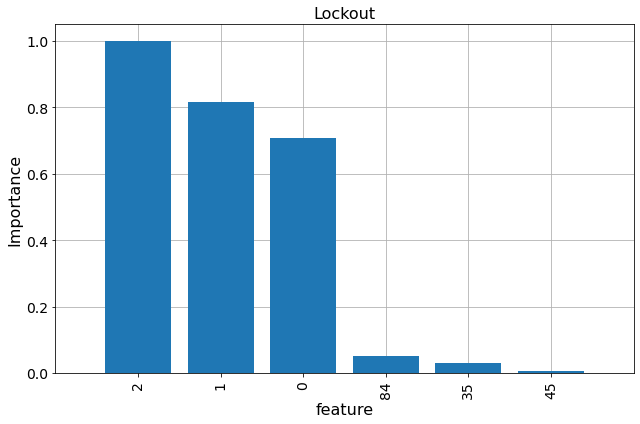

In [133]:
# Graph Feature Importance
import matplotlib.pyplot as plt
import numpy as np
from lockout.pytorch_utils import get_features_importance

importance = get_features_importance(model_lockout_option2a, 'linear_layers.0.weight')

fig, axes = plt.subplots(figsize=(9,6))
x_pos = np.arange(len(importance))
axes.bar(x_pos, importance, zorder=2)
axes.set_xticks(x_pos)
axes.set_xticklabels(importance.index, rotation='vertical')
axes.set_xlim(-1,len(x_pos))
axes.tick_params(axis='both', which='major', labelsize=14)
axes.set_ylabel('Importance', fontsize=16)
axes.set_xlabel('feature', fontsize=16)
axes.set_title('Lockout', fontsize=16)
axes.grid(True, zorder=1)

plt.tight_layout()
plt.savefig('feature_importance_lockout2a.pdf', bbox_inches='tight')
plt.show()

In [132]:
# Compute Test Accuracy
import torch
from lockout.pytorch_utils import dataset_r2

device = torch.device('cpu')
r2_test_forward, _   = dataset_r2(dl_test, model_forward_best, device)
r2_test_lockout2a, _ = dataset_r2(dl_test, model_lockout_option2a, device)
print("Test R2 (unconstrained) = {:.3f}".format(r2_test_forward))
print("Test R2 (lockout)       = {:.3f}".format(r2_test_lockout2a))

Test R2 (unconstrained) = 0.655
Test R2 (lockout)       = 0.953


b) Generated internally, in which case the $t_0$ points are linearly sampled

In [135]:
from lockout import Lockout

regul_type = [('linear_layers.0.weight', 1)]
regul_path = [('linear_layers.0.weight', True)]

# List of tuples (or dictionary) of the form [(layer_name, t0_number)] where:
# - layer_name: layer name in the input model (string)
# - t0_number: number of constraint values t0 to be linearly sampled (integer)
t0_points    = {'linear_layers.0.weight': 200}

# Instantiate Lockout
lockout_option2b = Lockout(lockout_forward.model_best_valid,  # initial network
                          lr=1e-2, 
                          loss_type=1,
                          regul_type=regul_type,
                          regul_path=regul_path, 
                          t0_points=t0_points)

# Train Neural Network With Lockout
lockout_option2b.train(dl_train, dl_valid, 
                      train_how="sampling_t0", 
                      epochs=5000,             # Max number of epochs used for first t0
                      epochs2=200,             # Max number of epochs used for the rest of the t0 values
                      early_stopping=20, 
                      tol_loss=1e-4)

n = 1


Epochs1:  20%|█▉        | 979/5000 [00:19<01:18, 51.33it/s]


Early stopping = True (980)

n = 2


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 51.66it/s]


Early stopping = True (24)

n = 3


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.83it/s]


Early stopping = True (24)

n = 4


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 51.10it/s]


Early stopping = True (24)

n = 5


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 51.00it/s]


Early stopping = True (25)

n = 6


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.16it/s]


Early stopping = True (24)

n = 7


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 51.55it/s]


Early stopping = True (24)

n = 8


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 51.13it/s]


Early stopping = True (24)

n = 9


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.89it/s]


Early stopping = True (24)

n = 10


Epochs1:  12%|█▏        | 23/200 [00:00<00:04, 35.69it/s]


Early stopping = True (24)

n = 11


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.98it/s]


Early stopping = True (24)

n = 12


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.60it/s]


Early stopping = True (24)

n = 13


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.60it/s]


Early stopping = True (24)

n = 14


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.52it/s]


Early stopping = True (24)

n = 15


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.69it/s]


Early stopping = True (24)

n = 16


Epochs1:  12%|█▏        | 23/200 [00:00<00:04, 35.41it/s]


Early stopping = True (24)

n = 17


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.48it/s]


Early stopping = True (24)

n = 18


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.23it/s]


Early stopping = True (24)

n = 19


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.74it/s]


Early stopping = True (24)

n = 20


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.92it/s]


Early stopping = True (24)

n = 21


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 51.11it/s]


Early stopping = True (24)

n = 22


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.88it/s]


Early stopping = True (24)

n = 23


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.52it/s]


Early stopping = True (24)

n = 24


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.20it/s]


Early stopping = True (24)

n = 25


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.87it/s]


Early stopping = True (24)

n = 26


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 49.93it/s]


Early stopping = True (24)

n = 27


Epochs1:  12%|█▏        | 23/200 [00:00<00:05, 33.91it/s]


Early stopping = True (24)

n = 28


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.24it/s]


Early stopping = True (24)

n = 29


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 49.59it/s]


Early stopping = True (24)

n = 30


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.37it/s]


Early stopping = True (24)

n = 31


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.75it/s]


Early stopping = True (24)

n = 32


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 49.59it/s]


Early stopping = True (24)

n = 33


Epochs1:  12%|█▏        | 23/200 [00:00<00:04, 35.57it/s]


Early stopping = True (24)

n = 34


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 51.04it/s]


Early stopping = True (24)

n = 35


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 49.96it/s]


Early stopping = True (24)

n = 36


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.62it/s]


Early stopping = True (24)

n = 37


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 51.27it/s]


Early stopping = True (24)

n = 38


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.94it/s]


Early stopping = True (24)

n = 39


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.32it/s]


Early stopping = True (24)

n = 40


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.22it/s]


Early stopping = True (24)

n = 41


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.23it/s]


Early stopping = True (24)

n = 42


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.10it/s]


Early stopping = True (24)

n = 43


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 51.08it/s]


Early stopping = True (24)

n = 44


Epochs1:  12%|█▏        | 23/200 [00:00<00:04, 35.57it/s]


Early stopping = True (24)

n = 45


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.31it/s]


Early stopping = True (24)

n = 46


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 49.89it/s]


Early stopping = True (24)

n = 47


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 49.32it/s]


Early stopping = True (24)

n = 48


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 49.84it/s]


Early stopping = True (24)

n = 49


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.52it/s]


Early stopping = True (24)

n = 50


Epochs1:  12%|█▏        | 23/200 [00:00<00:05, 35.03it/s]


Early stopping = True (24)

n = 51


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 51.45it/s]


Early stopping = True (24)

n = 52


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.92it/s]


Early stopping = True (24)

n = 53


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.60it/s]


Early stopping = True (24)

n = 54


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.78it/s]


Early stopping = True (24)

n = 55


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.90it/s]


Early stopping = True (24)

n = 56


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 51.09it/s]


Early stopping = True (24)

n = 57


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.81it/s]


Early stopping = True (24)

n = 58


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.41it/s]


Early stopping = True (24)

n = 59


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.76it/s]


Early stopping = True (24)

n = 60


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 49.62it/s]


Early stopping = True (24)

n = 61


Epochs1:  12%|█▏        | 23/200 [00:00<00:05, 35.17it/s]


Early stopping = True (24)

n = 62


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.89it/s]


Early stopping = True (24)

n = 63


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.44it/s]


Early stopping = True (24)

n = 64


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 50.65it/s]


Early stopping = True (25)

n = 65


Epochs1:  12%|█▏        | 23/200 [00:00<00:03, 50.61it/s]


Early stopping = True (24)

n = 66


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 50.80it/s]


Early stopping = True (25)

n = 67


Epochs1:  12%|█▏        | 24/200 [00:00<00:04, 35.67it/s]


Early stopping = True (25)

n = 68


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 50.34it/s]


Early stopping = True (25)

n = 69


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 49.39it/s]


Early stopping = True (25)

n = 70


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 50.32it/s]


Early stopping = True (25)

n = 71


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 50.93it/s]


Early stopping = True (25)

n = 72


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 50.69it/s]


Early stopping = True (25)

n = 73


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 51.26it/s]


Early stopping = True (25)

n = 74


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 51.06it/s]


Early stopping = True (25)

n = 75


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 51.10it/s]


Early stopping = True (25)

n = 76


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 51.33it/s]


Early stopping = True (25)

n = 77


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 50.96it/s]


Early stopping = True (25)

n = 78


Epochs1:  12%|█▏        | 24/200 [00:00<00:04, 35.88it/s]


Early stopping = True (25)

n = 79


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 51.03it/s]


Early stopping = True (25)

n = 80


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 50.45it/s]


Early stopping = True (25)

n = 81


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 50.92it/s]


Early stopping = True (25)

n = 82


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 51.00it/s]


Early stopping = True (25)

n = 83


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 50.87it/s]


Early stopping = True (25)

n = 84


Epochs1:  12%|█▏        | 24/200 [00:00<00:04, 35.85it/s]


Early stopping = True (25)

n = 85


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 51.11it/s]


Early stopping = True (25)

n = 86


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 50.89it/s]


Early stopping = True (25)

n = 87


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 50.89it/s]


Early stopping = True (25)

n = 88


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 50.68it/s]


Early stopping = True (25)

n = 89


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 50.32it/s]


Early stopping = True (25)

n = 90


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 50.08it/s]


Early stopping = True (25)

n = 91


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 50.82it/s]


Early stopping = True (25)

n = 92


Epochs1:  12%|█▎        | 25/200 [00:00<00:03, 51.08it/s]


Early stopping = True (26)

n = 93


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 50.91it/s]


Early stopping = True (25)

n = 94


Epochs1:  12%|█▎        | 25/200 [00:00<00:04, 36.45it/s]


Early stopping = True (26)

n = 95


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 50.68it/s]


Early stopping = True (25)

n = 96


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 50.48it/s]


Early stopping = True (25)

n = 97


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 50.65it/s]


Early stopping = True (25)

n = 98


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 50.40it/s]


Early stopping = True (25)

n = 99


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 50.74it/s]


Early stopping = True (25)

n = 100


Epochs1:  12%|█▏        | 24/200 [00:00<00:04, 35.69it/s]


Early stopping = True (25)

n = 101


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 51.06it/s]


Early stopping = True (25)

n = 102


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 50.61it/s]


Early stopping = True (25)

n = 103


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 50.52it/s]


Early stopping = True (25)

n = 104


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 51.21it/s]


Early stopping = True (25)

n = 105


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 50.90it/s]


Early stopping = True (25)

n = 106


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 50.83it/s]


Early stopping = True (25)

n = 107


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 47.57it/s]


Early stopping = True (25)

n = 108


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 49.74it/s]


Early stopping = True (25)

n = 109


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 50.91it/s]


Early stopping = True (25)

n = 110


Epochs1:  12%|█▏        | 24/200 [00:00<00:05, 34.01it/s]


Early stopping = True (25)

n = 111


Epochs1:  12%|█▎        | 25/200 [00:00<00:03, 50.33it/s]


Early stopping = True (26)

n = 112


Epochs1:  12%|█▎        | 25/200 [00:00<00:03, 49.94it/s]


Early stopping = True (26)

n = 113


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 49.78it/s]


Early stopping = True (25)

n = 114


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 49.76it/s]


Early stopping = True (25)

n = 115


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 49.70it/s]


Early stopping = True (25)

n = 116


Epochs1:  12%|█▏        | 24/200 [00:00<00:05, 35.18it/s]


Early stopping = True (25)

n = 117


Epochs1:  12%|█▎        | 25/200 [00:00<00:03, 50.12it/s]


Early stopping = True (26)

n = 118


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 50.32it/s]


Early stopping = True (25)

n = 119


Epochs1:  12%|█▎        | 25/200 [00:00<00:03, 50.56it/s]


Early stopping = True (26)

n = 120


Epochs1:  12%|█▏        | 24/200 [00:00<00:03, 51.19it/s]


Early stopping = True (25)

n = 121


Epochs1:  13%|█▎        | 26/200 [00:00<00:03, 51.29it/s]


Early stopping = True (27)

n = 122


Epochs1:  13%|█▎        | 26/200 [00:00<00:03, 51.32it/s]


Early stopping = True (27)

n = 123


Epochs1:  13%|█▎        | 26/200 [00:00<00:03, 51.67it/s]


Early stopping = True (27)

n = 124


Epochs1:  13%|█▎        | 26/200 [00:00<00:03, 51.18it/s]


Early stopping = True (27)

n = 125


Epochs1:  13%|█▎        | 26/200 [00:00<00:03, 51.61it/s]


Early stopping = True (27)

n = 126


Epochs1:  13%|█▎        | 26/200 [00:00<00:04, 36.93it/s]


Early stopping = True (27)

n = 127


Epochs1:  13%|█▎        | 26/200 [00:00<00:03, 50.07it/s]


Early stopping = True (27)

n = 128


Epochs1:  13%|█▎        | 26/200 [00:00<00:03, 49.74it/s]


Early stopping = True (27)

n = 129


Epochs1:  13%|█▎        | 26/200 [00:00<00:03, 50.49it/s]


Early stopping = True (27)

n = 130


Epochs1:  13%|█▎        | 26/200 [00:00<00:03, 49.24it/s]


Early stopping = True (27)

n = 131


Epochs1:  14%|█▎        | 27/200 [00:00<00:04, 37.29it/s]


Early stopping = True (28)

n = 132


Epochs1:  13%|█▎        | 26/200 [00:00<00:03, 50.57it/s]


Early stopping = True (27)

n = 133


Epochs1:  14%|█▎        | 27/200 [00:00<00:03, 50.31it/s]


Early stopping = True (28)

n = 134


Epochs1:  13%|█▎        | 26/200 [00:00<00:03, 51.11it/s]


Early stopping = True (27)

n = 135


Epochs1:  13%|█▎        | 26/200 [00:00<00:03, 50.45it/s]


Early stopping = True (27)

n = 136


Epochs1:  13%|█▎        | 26/200 [00:00<00:03, 51.37it/s]


Early stopping = True (27)

n = 137


Epochs1:  16%|█▌        | 32/200 [00:00<00:03, 51.16it/s]


Early stopping = True (33)

n = 138


Epochs1:  12%|█▎        | 25/200 [00:00<00:03, 50.44it/s]


Early stopping = True (26)

n = 139


Epochs1:  14%|█▍        | 28/200 [00:00<00:03, 51.16it/s]


Early stopping = True (29)

n = 140


Epochs1:  20%|██        | 41/200 [00:01<00:03, 39.90it/s]


Early stopping = True (42)

n = 141


Epochs1:  13%|█▎        | 26/200 [00:00<00:03, 49.42it/s]


Early stopping = True (27)

n = 142


Epochs1:  14%|█▎        | 27/200 [00:00<00:03, 49.73it/s]


Early stopping = True (28)

n = 143


Epochs1:  19%|█▉        | 38/200 [00:00<00:03, 51.64it/s]


Early stopping = True (39)

n = 144


Epochs1:  13%|█▎        | 26/200 [00:00<00:03, 51.33it/s]


Early stopping = True (27)

n = 145


Epochs1:  16%|█▋        | 33/200 [00:00<00:04, 39.12it/s]


Early stopping = True (34)

n = 146


Epochs1:  18%|█▊        | 35/200 [00:00<00:03, 50.61it/s]


Early stopping = True (36)

n = 147


Epochs1:  13%|█▎        | 26/200 [00:00<00:03, 50.25it/s]


Early stopping = True (27)

n = 148


Epochs1:  15%|█▌        | 30/200 [00:00<00:03, 51.64it/s]


Early stopping = True (31)

n = 149


Epochs1:  14%|█▎        | 27/200 [00:00<00:03, 50.72it/s]


Early stopping = True (28)

n = 150


Epochs1:  27%|██▋       | 54/200 [00:01<00:02, 52.01it/s]


Early stopping = True (55)

n = 151


Epochs1:  28%|██▊       | 56/200 [00:01<00:02, 52.46it/s]


Early stopping = True (57)

n = 152


Epochs1:  14%|█▍        | 29/200 [00:00<00:04, 37.96it/s]


Early stopping = True (30)

n = 153


Epochs1:  48%|████▊     | 96/200 [00:01<00:01, 52.64it/s]


Early stopping = True (97)

n = 154


Epochs1:  14%|█▍        | 28/200 [00:00<00:03, 51.41it/s]


Early stopping = True (29)

n = 155


Epochs1:  16%|█▋        | 33/200 [00:00<00:04, 39.34it/s]


Early stopping = True (34)

n = 156


Epochs1:  26%|██▌       | 52/200 [00:00<00:02, 52.23it/s]


Early stopping = True (53)

n = 157


Epochs1:  16%|█▋        | 33/200 [00:00<00:03, 51.01it/s]


Early stopping = True (34)

n = 158


Epochs1:  38%|███▊      | 77/200 [00:01<00:02, 52.35it/s]


Early stopping = True (78)

n = 159


Epochs1:  24%|██▍       | 48/200 [00:00<00:02, 50.72it/s]


Early stopping = True (49)

n = 160


Epochs1:  78%|███████▊  | 157/200 [00:03<00:00, 49.62it/s]


Early stopping = True (158)

n = 161


Epochs1:  85%|████████▌ | 170/200 [00:03<00:00, 50.58it/s]


Early stopping = True (171)

n = 162


Epochs1:  16%|█▋        | 33/200 [00:00<00:03, 50.89it/s]


Early stopping = True (34)

n = 163


Epochs1:  25%|██▌       | 50/200 [00:00<00:02, 52.41it/s]


Early stopping = True (51)

n = 164


Epochs1:  40%|████      | 81/200 [00:01<00:02, 46.23it/s]


Early stopping = True (82)

n = 165


Epochs1:  36%|███▌      | 71/200 [00:01<00:02, 52.18it/s]


Early stopping = True (72)

n = 166


Epochs1:  18%|█▊        | 37/200 [00:00<00:03, 40.80it/s]


Early stopping = True (38)

n = 167


Epochs1:  98%|█████████▊| 196/200 [00:03<00:00, 53.91it/s]


Early stopping = True (197)

n = 168


Epochs1:  16%|█▌        | 32/200 [00:00<00:03, 52.06it/s]


Early stopping = True (33)

n = 169


Epochs1: 100%|██████████| 200/200 [00:04<00:00, 48.95it/s]


Early stopping = False (200)

n = 170


Epochs1:  70%|███████   | 141/200 [00:02<00:01, 53.73it/s]


Early stopping = True (142)

n = 171


Epochs1:  34%|███▍      | 68/200 [00:01<00:02, 53.40it/s]


Early stopping = True (69)

n = 172


Epochs1:  80%|████████  | 161/200 [00:03<00:00, 50.41it/s]


Early stopping = True (162)

n = 173


Epochs1:  67%|██████▋   | 134/200 [00:02<00:01, 49.63it/s]


Early stopping = True (135)

n = 174


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 51.56it/s]


Early stopping = False (200)

n = 175


Epochs1:  19%|█▉        | 38/200 [00:00<00:03, 51.77it/s]


Early stopping = True (39)

n = 176


Epochs1:  31%|███       | 62/200 [00:01<00:02, 52.83it/s]


Early stopping = True (63)

n = 177


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 51.50it/s]


Early stopping = False (200)

n = 178


Epochs1:  60%|█████▉    | 119/200 [00:02<00:01, 49.26it/s]


Early stopping = True (120)

n = 179


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 51.58it/s]


Early stopping = False (200)

n = 180


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 51.58it/s]


Early stopping = False (200)

n = 181


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 51.33it/s]


Early stopping = False (200)

n = 182


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 50.62it/s]


Early stopping = False (200)

n = 183


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 50.17it/s]


Early stopping = False (200)

n = 184


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 53.38it/s]


Early stopping = False (200)

n = 185


Epochs1: 100%|██████████| 200/200 [00:04<00:00, 48.96it/s]


Early stopping = False (200)

n = 186


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 54.07it/s]


Early stopping = False (200)

n = 187


Epochs1: 100%|██████████| 200/200 [00:04<00:00, 48.92it/s]


Early stopping = False (200)

n = 188


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 53.97it/s]


Early stopping = False (200)

n = 189


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 51.34it/s]


Early stopping = False (200)

n = 190


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 51.30it/s]


Early stopping = False (200)

n = 191


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 51.33it/s]


Early stopping = False (200)

n = 192


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 51.07it/s]


Early stopping = False (200)

n = 193


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 50.87it/s]


Early stopping = False (200)

n = 194


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 50.85it/s]


Early stopping = False (200)

n = 195


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 50.84it/s]


Early stopping = False (200)

n = 196


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 50.91it/s]


Early stopping = False (200)

n = 197


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 51.10it/s]


Early stopping = False (200)

n = 198


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 51.03it/s]


Early stopping = False (200)

n = 199


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 50.67it/s]


Early stopping = False (200)

n = 200


Epochs1: 100%|██████████| 200/200 [00:03<00:00, 51.08it/s]

Early stopping = False (200)

Best validation at iteration = 198


In [186]:
# Path Data
df2b = lockout_option2b.path_data
df2b.head()

,iteration,sparcity__linear_layers.0.weight,t0_calc__linear_layers.0.weight,t0_used__linear_layers.0.weight,train_loss,valid_loss,train_accu,valid_accu
0,980,1.0,54.207325,54.207119,0.034422,0.891790,0.965578,0.170606
1,24,1.0,53.935425,53.934721,0.033113,0.893095,0.966887,0.169392
2,24,1.0,53.663013,53.662324,0.031916,0.895570,0.968084,0.167090
3,24,1.0,53.390324,53.389926,0.030784,0.897732,0.969216,0.165079
4,25,1.0,53.118298,53.117529,0.029654,0.898822,0.970346,0.164066


In [136]:
# Save Model At Validation Minimum
model_lockout_option2b = lockout_option2b.model_best_valid
save_model(model_lockout_option2b, 'model_lockout_option2b.pth')

In [137]:
# Compute Test Accuracy
import torch
from lockout.pytorch_utils import dataset_r2

device = torch.device('cpu')
r2_test_forward, _   = dataset_r2(dl_test, model_forward_best, device)
r2_test_lockout2b, _ = dataset_r2(dl_test, model_lockout_option2b, device)
print("Test R2 (unconstrained) = {:.3f}".format(r2_test_forward))
print("Test R2 (lockout)       = {:.3f}".format(r2_test_lockout2b))

Test R2 (unconstrained) = 0.655
Test R2 (lockout)       = 0.956


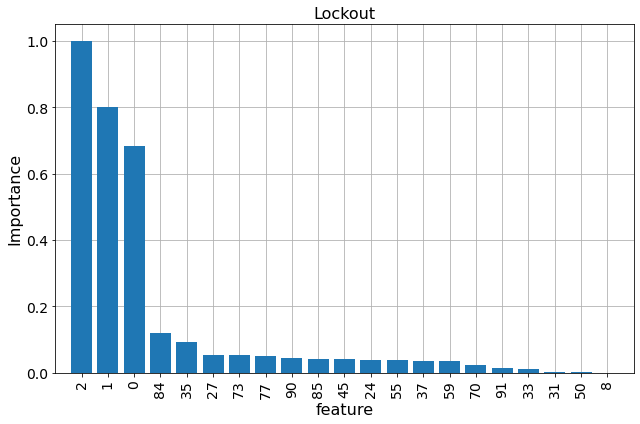

In [22]:
# Graph Feature Importance
import matplotlib.pyplot as plt
import numpy as np
from lockout.pytorch_utils import get_features_importance

importance = get_features_importance(model_lockout_option2b, 'linear_layers.0.weight')

fig, axes = plt.subplots(figsize=(9,6))
x_pos = np.arange(len(importance))
axes.bar(x_pos, importance, zorder=2)
axes.set_xticks(x_pos)
axes.set_xticklabels(importance.index, rotation='vertical')
axes.set_xlim(-1,len(x_pos))
axes.tick_params(axis='both', which='major', labelsize=14)
axes.set_ylabel('Importance', fontsize=16)
axes.set_xlabel('feature', fontsize=16)
axes.set_title('Lockout', fontsize=16)
axes.grid(True, zorder=1)

plt.tight_layout()
plt.savefig('feature_importance_lockout2b.pdf', bbox_inches='tight')
plt.show()

## Lockout Training: Option 3
Within this option, the neural network is trained with a single (constant) value of $t_0$ until the regularization path is found.

In [5]:
from lockout import Lockout

regul_type = [('linear_layers.0.weight', 1)]

# List of tuples (or dictionary) of the form [(layer_name, t0_value)] where:
# - layer_name: layer name in the input model (string)
# - t0_value: constraint value t0 used in the layer (tensor)
t0 = {'linear_layers.0.weight': torch.tensor(0.4)}

# Instantiate Lockout
lockout_option3 = Lockout(model_lockout_option2b,  # initial network
                          lr=1e-3, 
                          loss_type=1,
                          regul_type=regul_type,
                          t0=t0)

# Train Neural Network With Lockout
lockout_option3.train(dl_train, dl_valid, 
                      train_how="constant_t0", 
                      epochs=10000,              # Max number of epochs
                      early_stopping=20, 
                      tol_loss=1e-5)

Epochs1:  11%|█         | 1070/10000 [00:20<02:52, 51.66it/s]

Early stopping = True
Last iteration = 1071
Best validation at iteration = 936


In [14]:
# Path Data
df3 = lockout_option3.path_data
df3.tail()

,iteration,sparcity__linear_layers.0.weight,t0_calc__linear_layers.0.weight,t0_used__linear_layers.0.weight,train_loss,valid_loss,train_accu,valid_accu
1066,1067,0.07,0.4,0.4,0.501023,0.565949,0.498977,0.473649
1067,1068,0.07,0.4,0.4,0.501015,0.565923,0.498985,0.473673
1068,1069,0.07,0.4,0.4,0.501021,0.565942,0.498979,0.473655
1069,1070,0.07,0.4,0.4,0.501016,0.566030,0.498984,0.473573
1070,1071,0.07,0.4,0.4,0.501018,0.566230,0.498982,0.473387


In [15]:
# Save Model At Regularization Path
from lockout.pytorch_utils import save_model

model_lockout_option3 = lockout_option3.model_last
save_model(model_lockout_option3, 'model_lockout_option3.pth')

In [20]:
# Compute Test Accuracy
import torch
from lockout.pytorch_utils import dataset_r2

device = torch.device('cpu')
r2_test_forward, _  = dataset_r2(dl_test, model_forward_best, device)
r2_test_lockout3, _ = dataset_r2(dl_test, model_lockout_option3, device)
print("Test R2 (unconstrained) = {:.3f}".format(r2_test_forward))
print("Test R2 (lockout)       = {:.3f}".format(r2_test_lockout3))

Test R2 (unconstrained) = 0.655
Test R2 (lockout)       = 0.954


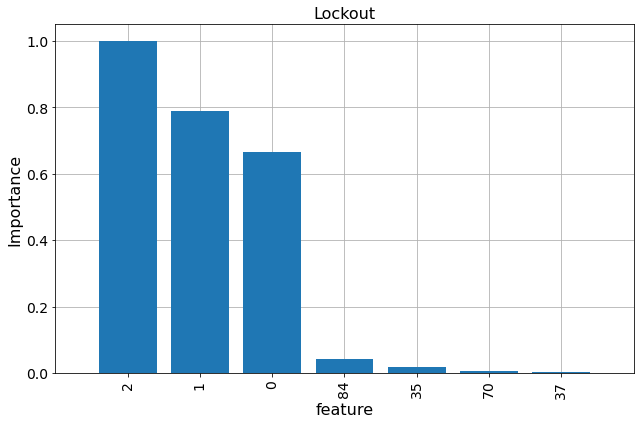

In [23]:
# Graph Feature Importance
import matplotlib.pyplot as plt
import numpy as np
from lockout.pytorch_utils import get_features_importance

importance = get_features_importance(model_lockout_option3, 'linear_layers.0.weight')

fig, axes = plt.subplots(figsize=(9,6))
x_pos = np.arange(len(importance))
axes.bar(x_pos, importance, zorder=2)
axes.set_xticks(x_pos)
axes.set_xticklabels(importance.index, rotation='vertical')
axes.set_xlim(-1,len(x_pos))
axes.tick_params(axis='both', which='major', labelsize=14)
axes.set_ylabel('Importance', fontsize=16)
axes.set_xlabel('feature', fontsize=16)
axes.set_title('Lockout', fontsize=16)
axes.grid(True, zorder=1)

plt.tight_layout()
plt.savefig('feature_importance_lockout3.pdf', bbox_inches='tight')
plt.show()

## Lockout Training: Option 4
Within this option, the neural network is trained until the regularization path is found. The contraint value used, $t_0$ is computed from the input model.

In [29]:
from lockout import Lockout

regul_type = [('linear_layers.0.weight', 1)]

# Instantiate Lockout
lockout_option4 = Lockout(model_forward_best,  # initial network
                          lr=1e-2, 
                          loss_type=1,
                          regul_type=regul_type)

# Train Neural Network With Lockout
lockout_option4.train(dl_train, dl_valid, 
                      train_how="until_path", 
                      epochs=10000,            # Max number of epochs
                      early_stopping=20, 
                      tol_loss=1e-5)

Epochs1:  20%|██        | 2011/10000 [00:38<02:32, 52.46it/s]

Early stopping = True
Last iteration = 2012
Best validation at iteration = 4


In [35]:
# Path Data
df4 = lockout_option4.path_data
df4.tail()

,iteration,sparcity__linear_layers.0.weight,t0_calc__linear_layers.0.weight,t0_used__linear_layers.0.weight,train_loss,valid_loss,train_accu,valid_accu
2007,2008,1.0,54.208427,54.207119,0.002655,0.994821,0.997345,0.074784
2008,2009,1.0,54.208115,54.207119,0.002647,0.994602,0.997353,0.074987
2009,2010,1.0,54.208317,54.207119,0.002641,0.994861,0.997359,0.074746
2010,2011,1.0,54.207520,54.207119,0.002634,0.994811,0.997366,0.074793
2011,2012,1.0,54.208824,54.207119,0.002625,0.995240,0.997375,0.074394


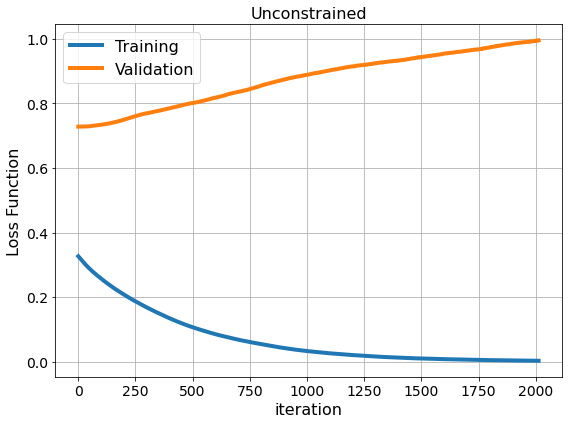

In [34]:
# Plot loss vs iteration
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(figsize=(8,6))

axes.plot(df4["iteration"], df4["train_loss"], label="Training", linewidth=4)
axes.plot(df4["iteration"], df4["valid_loss"], label="Validation", linewidth=4)
axes.legend(fontsize=16)
axes.set_xlabel("iteration", fontsize=16)
axes.set_ylabel("Loss Function", fontsize=16)
axes.tick_params(axis='both', which='major', labelsize=14)
axes.set_title("Unconstrained", fontsize=16)
axes.grid(True, zorder=2)

plt.tight_layout()
# plt.savefig("loss_vs_iter_lockout4.pdf", bbox_inches='tight')
plt.show()